# Whale Classification from echo-location clicks

In [3]:
from IPython.display import Image

This project is based on underwater sound data collected in the Gulf of Mexico during and since the time of the Deepwater Horizon oil spill in 2010. The task is to assess what species of whales were present at three recording sites, one near to the leaking well, and two others just outside the bounds of the spill. Here is a map of the Gulf of Mexico showing the recording site locations (dots) and the oiled area (gray).

<img src="./intro.jpg" height=500 width=500>

The classification was performed using the echo-location clicks emitted by beaked whales. These are very short pulses (less than a ms) that whales and dolphins use to sense their surroundings, including the detection of their prey. Different species of beaked whales emit clicks with different waveforms and spectral distributions. The time intervals between clicks also provides information about the species. Examples clicks from Cuvier’s and Gervais’ beaked whales are shown below.

<img src="./Cuv_Ger.jpg" height=500 width=500>

The task is simplified by the fact that whales usually occur in groups all belonging to the same species. The clicks can be separated into “runs” of clicks, each usually corresponding to a single species, separated by periods without clicks.

The classification was done by hand by Professor Hildebrand and became the basis for an estimate of the numbers of animals present at these sites. These results were presented in: Hildebrand, J. A., Baumann-Pickering, S., Frasier, K. E., Trickey, J. S., Merkens, K. P., Wiggins, S. M., McDonald, M. A., Garrison, L. P., Harris, D., Marques, T. A., and Thomas, L. (2015). "Passive acoustic monitoring of beaked whale densities in the Gulf of Mexico," Scientific Reports 5, 16343.

The goal of the proposed project is to create a classifier that takes as input data a run of clicks and outputs the species that is found in that run.

Beyond this project, there are many potential follow-up projects, related to analyzing various sounds emitted by marine mammals, including songs of baleen whales.

Peta-bytes of underwater audio data have been collected by Scripps and other oceanographic institutions, and the systematic analysis of these data is in it’s infancy. There is many opportunities for people with the relevant skills in big data analysis and signal processing to get involved in the process of discovering the information contained in sound and other oceanographic data.

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

## Importing require dependencies and starting a spark context

In [2]:
from pyspark import SparkContext
sc = SparkContext(pyFiles=['lib/row_parser.py','lib/spark_PCA.py'])

from pyspark.sql import Row, SQLContext, DataFrame
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

In [3]:
%pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat, savemat, whosmat

from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob
from time import time
import sys
from row_parser import *
from spark_PCA import *
from pyspark.sql import DataFrame

Populating the interactive namespace from numpy and matplotlib


## The Dataset
The full dataset has 6.5 million clicks with data of the size of about 27GB. After filtering the mis-classified clicks and faulty data, we end up with 4.1 million clicks of which 1.9 million are Gervais and 2.2 million are Cuviers.

Here we use a sample of about 15MB in size that contains about 2000 samples from each species.

In [58]:
!ls -l Data/whale_data_15mb.np

-rw-r--r-- 1 jovyan users 15696962 May 20 21:35 Data/whale_data_15mb.np


In [4]:
file_data = np.load("Data/whale_data_15mb.np")
file_data_rdd = sc.parallelize(file_data.tolist())

In [5]:
schema = StructType([
     StructField('time', TimestampType(), True),
     StructField('species', StringType(), True),
     StructField('site', StringType(), True),
     StructField('rec_no', StringType(), True),
     StructField('bout_i', LongType(), True),
     StructField('peak2peak', DoubleType(), True),
     StructField('MSN', BinaryType(), True),
     StructField('MSP', BinaryType(), True),
     StructField('TPWS1', LongType(), True),
     StructField('MD1', LongType(), True),
     StructField('FD1', LongType(), True),
     StructField('TPWS2', LongType(), True),
     StructField('MD2', LongType(), True),
     StructField('FD2', LongType(), True),
     StructField('TPWS3', LongType(), True),
     StructField('MD3', LongType(), True),
     StructField('FD3', LongType(), True)
])

### Data schema
The data was originally stored as Matlab files. Those were translated into CSV files.

#### The feature vector
Each click is defined by the following fields

|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101

### The labels
Labels were assigned manually. Three passes were made on the data at increasing levels of scrutiny.
The labels used are those define by the second pass (where TPWS2 flag is set to 1)

#### Format of original matlab files

The name of the file defines the type of clicks stored in the file. The filename is formatted as follows:

|Name | site name | Recording number | Species | Type of file | Data Cleaning iteration |
|-|-----------|------------------|---------|--------------|-------------------------|
|**Field name in code** | site | rec_no | species | fields | no |
| | DT, GC, MC | 01,02,.. | Cuviers and Gerveis | **TPWS:** full data (waveforms) | no number == 1 |
| |            |          |                     | **MD:** click belongs to other species | |
| |            |          |                     | **FD:** click appearing in other species belongs here | |

**Question to John:** Is there a  field which defines the **final** species classification? If not, what is the formula for determining it from the recorded fields?

|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|1: species		| Initial species classification	        | 'str'
|309: TPWS1		| 1 if click appears in TPWS1	| 	bool
|310: MD1		|	--- " ---	in MD1|	bool
|311: FD1	    |	--- " ---	in FD1|	bool
|312: TPWS2		| 1 if click appears in TPWS2	| 	bool
|313: MD2		|	--- " ---	in MD2|	bool
|314: FD2	    |	--- " ---	in FD2|	bool
|315: TPWS3		| 1 if click appears in TPWS3	| 	bool
|316: MD3		|	--- " ---	in MD3|	bool
|317: FD3	    |	--- " ---	in FD3|	bool

In [53]:
df_new = sqlContext.createDataFrame(file_data_rdd, schema).cache()

In [54]:
#count the number of records (clicks) for each species
df_new.groupBy('species').count().collect()

[Row(species='Cuviers', count=2238), Row(species='Gervais', count=1937)]

In [55]:
def get_msn(row):
    """ extract MSN from row as numpy array"""
    return unpackArray(row.MSN,data_type=numpy.float64)
def get_msp(row):
    """ extract MSP from row as numpy array"""
    return unpackArray(row.MSP,data_type=numpy.float64)

### A few examples of waveforms and spectra for both species

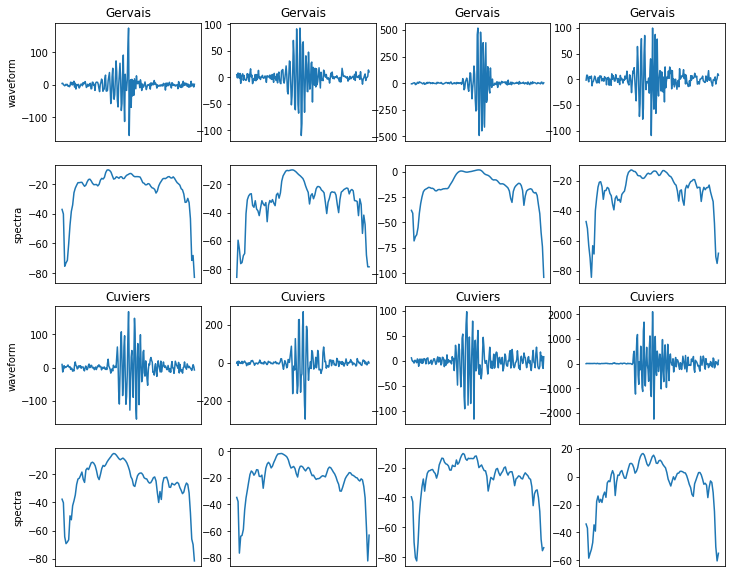

In [56]:
Gervais=df_new.filter(df_new.species=='Gervais').take(4)
Cuviers=df_new.filter(df_new.species=='Cuviers').take(4)

# After creating plot ...

#cur_axes = mplot.gca()
#cur_axes.axes.get_xaxis().set_ticks([])

figure(figsize=(12,10))
i=0

for row in Gervais+Cuviers:
    waveform=get_msn(row)
    spectra=get_msp(row)
    subplot(4,4,i+1)
    plot(waveform)
    title(row.species)
    gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        ylabel('waveform')
    subplot(4,4,i+5)
    plot(spectra)
    gca().axes.get_xaxis().set_ticks([])
    if(i %4)==0:
        ylabel('spectra')

    i+=1
    if i==4:
        i=8
   

## Our analysis is based on the spectra
The spectra is computed from the waveform using FFT

The only other information that is extracted from the waveform is `peak2peak` which measures the difference between the max and the min of the wave form.

In [57]:

spectra=df_new.rdd.map(get_msp)
COV=computeCov(spectra)

shape of E= (101,) shape of NE= (101,)


### Mean and covariance of spectra

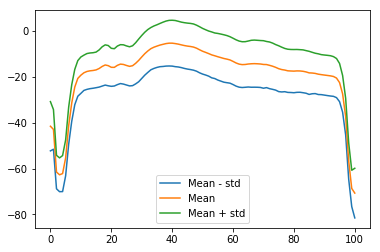

In [13]:
M=COV['Mean']
S=np.sqrt(COV['Var'])
plt.plot(M-S)
plt.plot(M)
plt.plot(M+S)
plt.legend(['Mean - std', 'Mean', 'Mean + std'])
plt.show()

### PCA of spectra



shape of E= (101,) shape of NE= (101,)


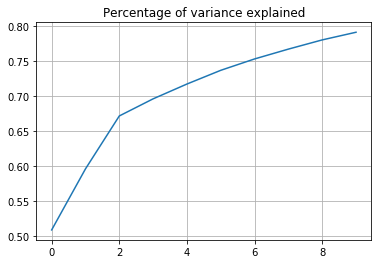

In [62]:
## please remove the print command that generates:
## shape of E= (101,) shape of NE= (101,)

## Get Spectra
spectra=df_new.rdd.map(trimmed_spectra)

## Extract Eigen Vectors
COV=computeCov(spectra)
eigval,eigvec=LA.eig(COV['Cov'])
eigval=eigval/sum(eigval)

## Check the Reconstruction
plot(cumsum(eigval[:10]))
grid()
title("Percentage of variance explained");

### Visualizing the first 4 eigen vectors

**Question to John:** `ev0` seems to relate to the overall magnitude of the spectra.  Can you interpret `ev1,ev2,ev3`?

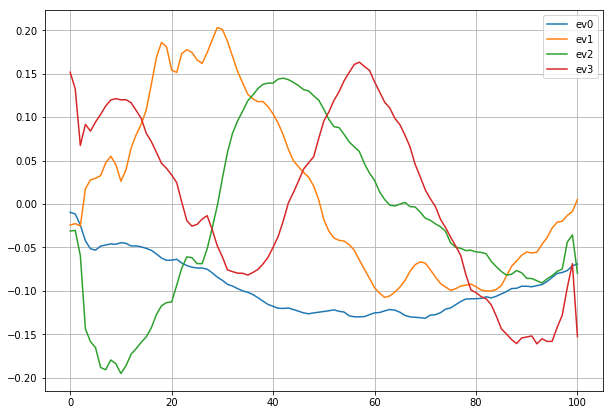

In [63]:
figure(figsize=[10,7])
for i in range(4):
    plot(eigvec[:,i],label='ev'+str(i))
legend()
grid()

**Something to do**: verify that all of the eigen-vectors have length 1.

In [66]:
## Using First 10 Eigen Vectors
V=eigvec[:,0:10]
## Defining a function to return Projection
def project(array):
    return np.dot(array, V)

## Creating Training Data

Returns the projection, rmse , peak2peak and the label 

In [67]:
def calc_stats(row):
    array = trimmed_spectra(row)
    projections = project(array)
    rmse = np.std(array)
    peak2peak = row.peak2peak
    label = 0 if row.species==u'Gervais' else 1
    return np.hstack((projections, [rmse, peak2peak, label]))

In [68]:
df_trimmed_data = df_new.rdd.map(calc_stats)

In [69]:
data = df_trimmed_data.collect()

### Writing Data

In [70]:
np_data = np.array(data)
np.save(open('Data/processed_data_15mb.np', 'wb'), np_data)

## Projecting on top eigenvectors
We observe that eigvec1 represents mostly the loudness of the click, and has little information about the species.

We therefor project on eigen-vectors 2 and 3.

In [85]:
V=eigvec[:,1:3] #vectors on which to project, chose 1,2 eigen vectors
def project(row):
    X=unpackArray(row.MSP,data_type=np.float64)
    return np.dot(X,V)

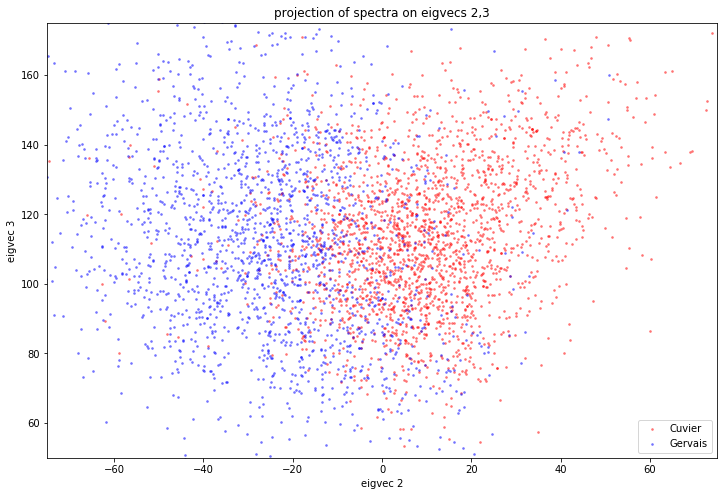

In [95]:
Cuvier_projections=np.array(Cuviers.rdd.map(project).collect())
Gervais_projections=np.array(Gervais.rdd.map(project).collect())

figure(figsize=[12,8])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', s=3, alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', s=3, alpha=0.4)
title('projection of spectra on eigvecs 2,3')
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-75,75])
xlabel('eigvec 2')
ylim([50,175])
ylabel('eigvec 3');

Observe that there are regions where the conditional probability is close to 0 or 1

There is also an overlap region where there two species are mixed.

### Highlighting overlap area

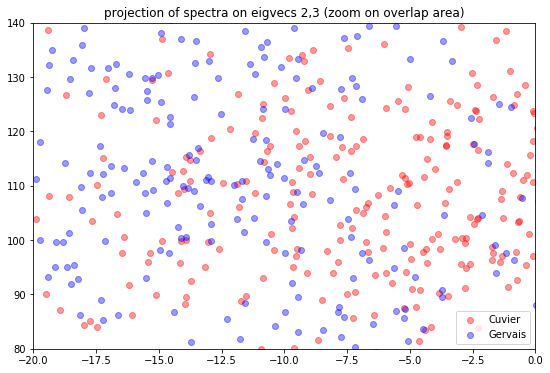

In [98]:
Cuvier_projections=np.array(Cuviers.sample(False,0.5).rdd.map(project).take(10000))
Gervais_projections=np.array(Gervais.sample(False,0.5).rdd.map(project).take(10000))

figure(figsize=[9,6])
scatter(Cuvier_projections[:,0],Cuvier_projections[:,1],c='r', alpha=0.4)
scatter(Gervais_projections[:,0],Gervais_projections[:,1],c='b', alpha=0.4)
title('projection of spectra on eigvecs 2,3 (zoom on overlap area)')
legend(['Cuvier', 'Gervais'], loc="lower right")
xlim([-20, 0])
ylim([80, 140]);

## Summary

* We are encouraged to see that projecting on eigvecs 2,3 gives a pretty good separation.
* There might be more useful information in the other eigenvectors, but we cannot visualize more than 2.
* We use the top eigenvectors and features and use boosting to extract more information.